In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  

In [1]:
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from rocket_tools import model, losses, image_gen
from rocket_tools.image_gen import gen_random_images
from rocket_tools.model import ZF_UNET_224
from rocket_tools.losses import dice_coef_loss

In [3]:
def preprocess_batch(batch):
    batch /= 256
    batch -= 0.5
    return batch

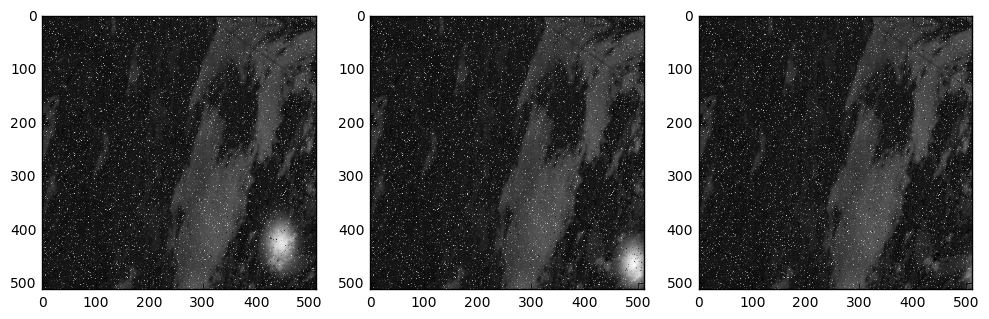

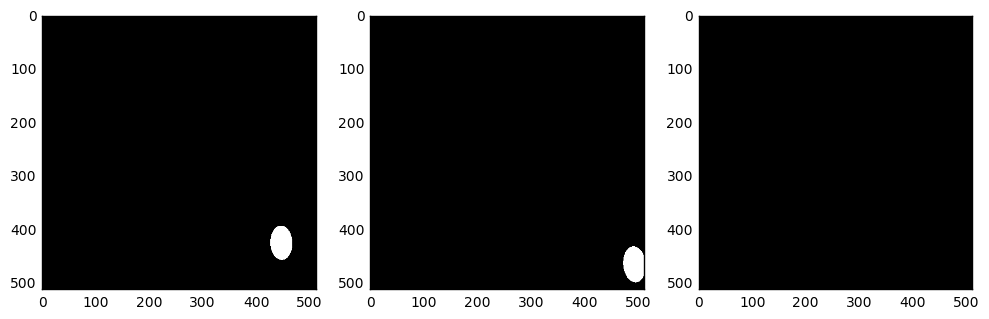

In [4]:
images, masks = gen_random_images()

f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax = axes[i]
    image = images[:, :, i] 
    ax.imshow(image, cmap='gray')
plt.show()

f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax = axes[i]
    image = masks[:, :, i] 
    ax.imshow(image, cmap='gray')
plt.show()

In [5]:
def a2img(array):
    array = np.clip(array[:, :, 0], 0, 255)
    array =  array.astype('int32')
    return array

In [6]:
def batch_generator(batch_size):
    while True:
        image_list = []
        mask_list = []
        for i in range(batch_size):
            img, mask = gen_random_images()
            image_list.append(img)
            mask_list.append(mask)

        image_list = np.array(image_list, dtype=np.float32)

        image_list = preprocess_batch(image_list)
        mask_list = np.array(mask_list, dtype=np.float32)
        yield image_list, mask_list

In [8]:
model = ZF_UNET_224()
model.load_weights('save_models/zf_unet_224.h5')

In [18]:
#out_model_path = 'zf_unet_224.h5'
#batch_size=64
#model = ZF_UNET_224()
#model.compile(Adam(), loss=dice_coef_loss, metrics=[dice_coef])
#
#print('Start training...')
#history = model.fit_generator(
#    generator=batch_generator(batch_size),
#     epochs=500,
#     steps_per_epoch=10,
#     validation_data=batch_generator(batch_size),
#     validation_steps=10,
#     verbose=1)
    
#model.save_weights(out_model_path)
#pd.DataFrame(history.history).to_csv('zf_unet_224_train.csv', index=False)

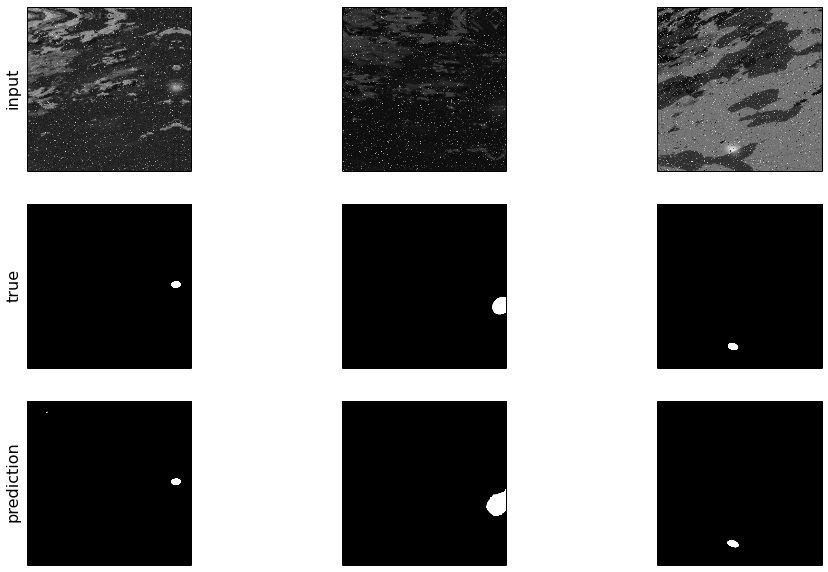

In [41]:
x_batch, y_batch = batch_generator(3).next()

y_pred = model.predict(x_batch)

f, axes = plt.subplots(3, 3, figsize=(16, 10))

axes[0, 0].set_ylabel('input', fontsize=16)
for i in range(3):
    ax = axes[0, i]
    ax.imshow(x_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[1, 0].set_ylabel('true', fontsize=16)
for i in range(3):
    ax = axes[1, i]
    ax.imshow(y_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[2, 0].set_ylabel('prediction', fontsize=16)
for i in range(3):
    ax = axes[2, i]
    ax.imshow(y_pred[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [22]:
!nvidia-smi

Sun Feb 18 18:40:11 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.74                 Driver Version: 375.74                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          On   | 0000:03:00.0     Off |                    0 |
| 23%   27C    P8    21W / 235W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          On   | 0000:04:00.0     Off |                    0 |
| 23%   43C    P0    63W / 235W |  11286MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Q